## はじめに

本ハンズオンでは機械学習の基礎を体験頂きます。コードの詳細は気にせずに、どういった手順で何をしようとしているのか、機械学習モデル構築の流れをご確認下さい。また不明な単語などありましたら、参考文献などでご確認を頂けたらと思います。

今回は機械学習モデルのチュートリアルでは定番のTitanicのデータを活用します。

今後のプロトタイピングを実施するに辺り、本ハンズオンを通してご確認頂きたい概念は下記です。
- 教師あり学習とは
- 探索的データ解析(EDA)から特徴量を作成する流れ
- 欠損データへの対応
- カテゴリカル変数の取り扱い(ダミー変数化など)
- 機械学習アルゴリズムのハイパーパラメータとは
- 交差検証とは

逆に、現時点で時間をかけて頂かなくて良い点は下記になります。
- 機械学習アルゴリズムそのもの(今回で言えば決定木アルゴリズム）
- Pythonライブラリのそれぞれの詳細(numpy, pandas, scikit-learnなど)

In [ ]:
#scikit-learnのバージョン更新
!conda update -y scikit-learn

In [ ]:
#データのダウンロードと解凍
!wget http://bit.ly/2KEZlRT
!unzip -o 2KEZlRT

### データの確認
まずは元データについて確認をします。今回は簡単にデータサイズ、カラム名、サンプルの抽出を実施します。

In [1]:
# ライブラリーのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from pylab import rcParams

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
%matplotlib inline

np.random.seed(1)

#データの読み込み
train = pd.read_csv("titanic-data/train.csv")
test = pd.read_csv("titanic-data/test.csv")

#データセットのサイズの確認
print("=====元データのサイズは下記====")
print(train.shape)
print(test.shape)


#データセットのカラム名の確認
print("=====元データのカラムは下記====")
print(train.columns)

#どのようなデータセットになっているのか、サンプルを5個抽出
train.sample(5)

=====元データのサイズは下記====
(891, 12)
(418, 11)
=====元データのカラムは下記====
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
223,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
535,536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.2500,NaN,S


今回のデータセットで変数の種類はそれぞれ下記となっています。
- Boolian: Survived
- Numerical: Age (連続値), Fare (連続値), SibSp (離散値), Parch (離散値)
- Categorical: Survived, Sex, Embarked, Pclass
- Alphanumeric: Ticket, Cabin

### 欠損値の確認
今回のデータはいくつかの特徴量において欠損があるためそれぞれに対応する必要があります。先程のサンプルでも`Cabin`の各データは全て"NaN"で欠損しています。他の特徴にも欠損が無いか見てみましょう。

In [2]:
#欠損値の確認
print(pd.isnull(train).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### EDA(Exploratory Data Analysis)：探索的データ解析
EDAの結果、下記のようなことがわかります。

- 今回のデータは学習データに891人、テストデータに418人の乗客がそれぞれいる
- Sex: 女性の方が生存しやすい
- SibSp/Parch: 一人で旅行している乗客ほど生存しやすい
- Age: 幼い子どもほど生存しやすい
- Pclass: Pclassの高い乗客ほど生存しやすい
- 約2割のデータで年齢が欠損しています。年齢によって生存率が大きく異なる
- キャビンについては約8割のデータが欠損している

その他にも今回のデータセットを確認すると様々なことがわかります。本ハンズオンでは詳細を確認しませんので、ご興味ある方が、他の方々が実施されている内容をご参考に下さい。
- [Scikit-Learn ML from Start to Finish](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish)
- [Titanic Survival Predictions (Beginner)](https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner)
- [Titanic top 10% - My first competition](https://www.kaggle.com/benteo/titanic-top-10-my-first-competition)

## データ前処理と特徴量作成
ここから先は現在あるデータを用いて機械学習モデルの精度が向上するようなデータを作成します。
- 欠損しているデータを活用できる形へ変換したり埋めたりする
- 機械学習モデルにとってより意味のある特徴量を作成する
- カテゴリカル変数を機械学習モデルへ投入できるようなダミー変数へと変換する

下記の方針で前処理と特徴量作成を実施します。
- Cabin：記録が残っている乗客の方が生存率が高いため、記録あり、無し(欠損)、を特徴量とする
- Embarked：乗客の多くがSouthamptonから乗船しているので、記載が無い乗客もSouthamptonから乗船したことにして欠損埋めをする
- Age：年齢が若いほうが生存が高いが、欠損が多いため活用が難しい。他のデータから年齢を推測した上で、グループ化して活用
    - `Name`特徴量中から`Title`を抽出
    - `Title`から年齢がどの程度が推察し`AgeGroup`特徴量を作成
- Fare：欠損値を適当な値で埋めた後に四分位毎にグループ化

最終的に機械学習モデルが学習できるようカテゴリカル変数をダミー変数化します。

### Cabin特徴量
`Cabin`に記録が残っている乗客の方が生存率が高いため、記録あり、無し(欠損)、を特徴量とする。

In [3]:
train["Cabin"] = train["Cabin"].notnull().astype('int')
test["Cabin"] = test["Cabin"].notnull().astype('int')

#作った特徴量の確認
train["Cabin"].head()

0    0
1    1
2    0
3    1
4    0
Name: Cabin, dtype: int64

### Embarked特徴量
乗客の多くがSouthamptonから乗船しているので、記載が無い乗客もSouthamptonから乗船したこととして欠損埋めを実施。

In [4]:
print("Southampton(S)からの乗客数:" + str(train[train["Embarked"] == "S"].shape[0]))
print("Cherbourg(C)からの乗客数:" + str(train[train["Embarked"] == "C"].shape[0]))
print("Queenstown(Q)からの乗客数:"+ str(train[train["Embarked"] == "Q"].shape[0]))

train = train.fillna({"Embarked": "S"})
test = train.fillna({"Embarked": "S"})

#作った特徴量の確認
train["Embarked"].head()

Southampton(S)からの乗客数:644
Cherbourg(C)からの乗客数:168
Queenstown(Q)からの乗客数:77


0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

### Age特徴量
元のデータは多くの人の年齢情報が欠損しています。今回は名前についている`Title`から年齢を推測して活用しましょう。

In [5]:
#年齢をそのまま使わずにグループに変換
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ["Unknown", "Baby", "Child", "Teenager", "Student", "Young Adult", "Adult", "Senior"]
train["AgeGroup"] = pd.cut(train["Age"], bins, labels = labels)
test["AgeGroup"] = pd.cut(test["Age"], bins, labels = labels)

#学習データとテストデータの`Name`特徴量から`Title`部分を抽出
combine = [train, test]
for dataset in combine:
    dataset["Title"] = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
    
#様々なタイトルをより一般的なタイトルへ変換します
for dataset in combine:
    dataset["Title"] = dataset["Title"].replace(["Lady", "Capt", "Col",
    "Don", "Dr", "Major", "Rev", "Jonkheer", "Dona"], "Rare")
    
    dataset["Title"] = dataset["Title"].replace(["Countess", "Lady", "Sir"], "Royal")
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")
    dataset["Title"] = dataset["Title"].fillna("NaN")

#作った特徴量の確認
print(train["Title"].head())

train[["Title", "Survived"]].groupby(["Title"], as_index=False).mean()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


`Mr`がついている方の生存率が極端に低い一方、`Miss`や`Mrs`の生存率が高いことがわかります。Royalは確実に生き残っているところには感じ入るものがあります。指名から抽出したタイトルをもとにして、どの年齢カテゴリなのかを推察します。

In [6]:
age_title_mapping = {"Mr": "Young Adult", "Miss": "Student", "Mrs": "Adult", "Master": "Baby", "Royal": "Adult", "Rare": "Adult"}

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]
        
for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]
        
        
#作った特徴量の確認        
train["AgeGroup"].head()

0        Student
1          Adult
2    Young Adult
3    Young Adult
4    Young Adult
Name: AgeGroup, dtype: category
Categories (8, object): [Unknown < Baby < Child < Teenager < Student < Young Adult < Adult < Senior]

### Fare特徴量
欠損値を欠損していたことがわかりやすい適当な値で埋めた上で、四分位毎でビンで区切って離散化します。

In [7]:
train["Fare"] = train["Fare"].fillna(-0.5)
test["Fare"] = train["Fare"].fillna(-0.5)
bins = (-1, 0, 8, 15, 31, 1000)

group_names = ["Unknown", "1_quartile", "2_quartile", "3_quartile", "4_quartile"]

train["Fare"] = pd.cut(train["Fare"], bins, labels=group_names)
test["Fare"] = pd.cut(test["Fare"], bins, labels=group_names)

#作った特徴量の確認
train["Fare"].head()

0    1_quartile
1    4_quartile
2    1_quartile
3    4_quartile
4    2_quartile
Name: Fare, dtype: category
Categories (5, object): [Unknown < 1_quartile < 2_quartile < 3_quartile < 4_quartile]

### ダミー変数化(ダミーエンコーディング)
カテゴリカル変数をダミー変数化(ダミーエンコーディング)します。対象となるのは、`Title`、`Embarked`、`AgeGroup`、`Fare`、`Sex`です。

In [8]:
#処理しやすいように学習データとテストデータを結合
data = pd.concat([train,test], axis=0, sort="True")

title_dummies = pd.get_dummies(data["Title"], prefix="Title")
data = pd.concat([data, title_dummies], axis=1)
data = data.drop(["Title"], axis=1)

embarked_dummies = pd.get_dummies(data["Embarked"], prefix="Embarked")
data = pd.concat([data, embarked_dummies], axis=1)
data = data.drop(["Embarked"], axis=1)

agegroup_dummies = pd.get_dummies(data["AgeGroup"], prefix="AgeGroup")
data = pd.concat([data, agegroup_dummies], axis=1)
data = data.drop(["AgeGroup"], axis=1)

fare_dummies = pd.get_dummies(data["Fare"], prefix="Fare")
data = pd.concat([data, fare_dummies], axis=1)
data = data.drop(["Fare"], axis=1)

sex_mapping = {"male": 0, "female": 1}
data["Sex"] = data["Sex"].map(sex_mapping)

### 特徴量の削除
あまり有用な情報がなかったり特徴量作成のベースとして使った特徴量を削除します。対象となるのは`Age`、`Name`、`Ticket`、`PassengerId`です。

In [9]:
#使わない特徴量の削除
data = data.drop(["Age", "Ticket", "Name", "PassengerId"], axis = 1)

#結合したデータを再び学習データとテストデータへ分離
train = data.iloc[:len(train)]
test = data.iloc[-len(test):].drop(["Survived"], axis=1)

## データの確認
最終的にモデル構築に使うデータを確認してみましょう。

In [10]:
data.head()

,Cabin,Parch,Pclass,Sex,SibSp,Survived,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,AgeGroup_Teenager,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Fare_Unknown,Fare_1_quartile,Fare_2_quartile,Fare_3_quartile,Fare_4_quartile
0,0,0,3,0,1,0,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,1,0,1,1,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
2,0,0,3,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,1,1,1,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,0,0,3,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [11]:
test.head()

,Cabin,Parch,Pclass,Sex,SibSp,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,...,AgeGroup_Teenager,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,Fare_Unknown,Fare_1_quartile,Fare_2_quartile,Fare_3_quartile,Fare_4_quartile
0,0,0,3,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,1,0,1,1,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,0,0,3,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,1,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,3,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


## 機械学習モデルの構築
作成した特徴量を用いて機械学習モデルを学習させます。今回使うアルゴリズムは決定木になります。決定木のハイパーパラメータの中で木の深さと、各ノードでの最小のデータ数についてグリッドサーチで探索して最適化します。探索した中で一番精度のよいハイパーパラメータを持つモデルを活用して未知のデータ（テストデータ)について推論します。

In [12]:
decisiontree = DecisionTreeClassifier()

#学習データを正解データと特徴量にわけます
X = train.drop(["Survived"], axis=1)
y = train["Survived"]

In [13]:
#ハイパーパラメータ探索のためののパラメータグリッドを作成
param_grid = {
    "max_depth":[3, 5, 7],
    "min_samples_split":[10, 30, 50]}

#グリッドサーチで求めるそれぞれのハイパーパラメータの精度はCrossValidation（交差検証）で検証
gscv = GridSearchCV(decisiontree, param_grid, cv=4, verbose=2, return_train_score=True, scoring='accuracy')
gscv.fit(X, y)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] max_depth=3, min_samples_split=10 ...............................
[CV] ................ max_depth=3, min_samples_split=10, total=   0.0s
[CV] max_depth=3, min_samples_split=10 ...............................
[CV] ................ max_depth=3, min_samples_split=10, total=   0.0s
[CV] max_depth=3, min_samples_split=10 ...............................
[CV] ................ max_depth=3, min_samples_split=10, total=   0.0s
[CV] max_depth=3, min_samples_split=10 ...............................
[CV] ................ max_depth=3, min_samples_split=10, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ................ max_depth=3, min_samples_split=30, total=   0.0s
[CV] max_depth=3, min_samples_split=30 ...............................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................ max_depth=7, min_samples_split=30, total=   0.0s
[CV] max_depth=7, min_samples_split=50 ...............................
[CV] ................ max_depth=7, min_samples_split=50, total=   0.0s
[CV] max_depth=7, min_samples_split=50 ...............................
[CV] ................ max_depth=7, min_samples_split=50, total=   0.0s
[CV] max_depth=7, min_samples_split=50 ...............................
[CV] ................ max_depth=7, min_samples_split=50, total=   0.0s
[CV] max_depth=7, min_samples_split=50 ...............................
[CV] ................ max_depth=7, min_samples_split=50, total=   0.0s


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.2s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [10, 30, 50]},
             pre_dispatch=

### 交差検証の結果を確認
どのハイパーパラメーターが交差検証上で精度が良いかを確認してみます。

In [14]:
# 交差検証の結果をDataFrameで表示します。
pd.DataFrame.from_dict(gscv.cv_results_)[["params", "mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]]

,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,"{'max_depth': 3, 'min_samples_split': 10}",0.821549,0.006848,0.827903,0.009619
1,"{'max_depth': 3, 'min_samples_split': 30}",0.821549,0.006848,0.827903,0.009619
2,"{'max_depth': 3, 'min_samples_split': 50}",0.820426,0.008648,0.822297,0.000469
3,"{'max_depth': 5, 'min_samples_split': 10}",0.801347,0.036597,0.852967,0.007281
4,"{'max_depth': 5, 'min_samples_split': 30}",0.804714,0.026943,0.842117,0.009027
5,"{'max_depth': 5, 'min_samples_split': 50}",0.803591,0.025096,0.833892,0.005360
6,"{'max_depth': 7, 'min_samples_split': 10}",0.818182,0.011680,0.871676,0.003551
7,"{'max_depth': 7, 'min_samples_split': 30}",0.817059,0.009859,0.852599,0.006583
8,"{'max_depth': 7, 'min_samples_split': 50}",0.821549,0.013233,0.841009,0.007522


In [15]:
print("一番良かったハイパーパラメーターは {} でAccuracyスコアは {:.3g}。".format(gscv.best_params_, gscv.best_score_))

一番良かったハイパーパラメーターは {'max_depth': 3, 'min_samples_split': 10} でAccuracyスコアは 0.822。


### 推論
学習データでの交差検証で一番精度が良かったモデルを用いてテストデータを推論します。

In [16]:
best_decisiontree = gscv.best_estimator_
predictions = best_decisiontree.predict(test)
print(predictions)

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1
 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 1
 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 

### 決定木アルゴリズムの構造を可視化
決定木の構造を可視化し、どの特徴量が効いているのかについて把握します。

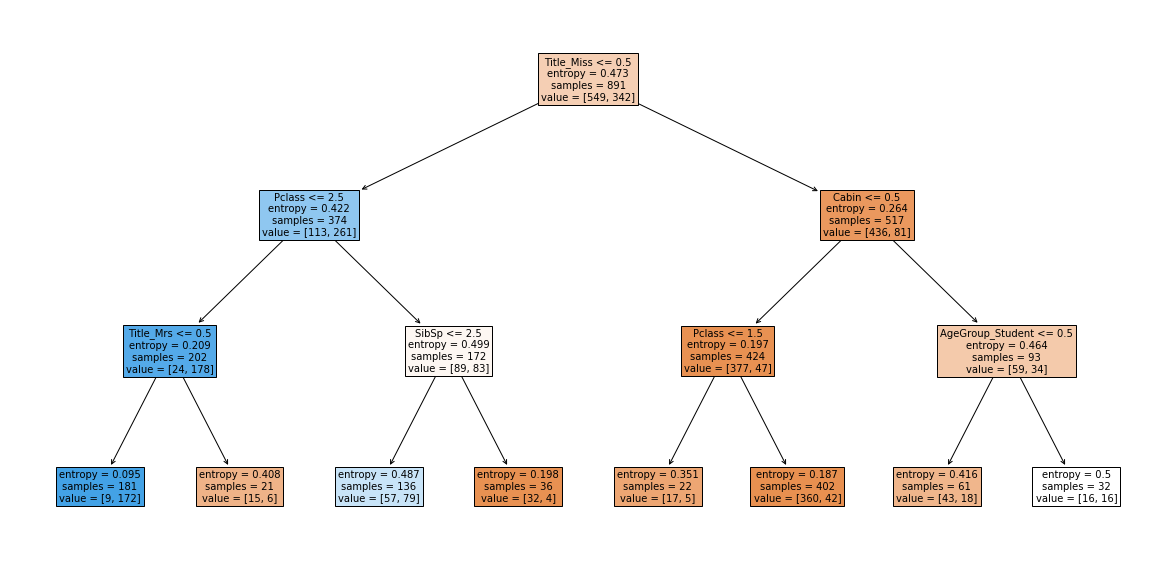

In [17]:
rcParams['figure.figsize'] = 20,10

plt.figure()
plot_tree(best_decisiontree.fit(X,y),feature_names=train.columns, filled=True)
plt.show()

## ご参考
- [Python機械学習ライブラリ scikit-learn活用レシピ80+](https://www.amazon.co.jp/dp/4295005746)
- [Pythonデータ分析/機械学習のための基本コーディング! pandasライブラリ活用入門 ](https://www.amazon.co.jp/dp/4295005657)
- [機械学習のための特徴量エンジニアリング](https://www.amazon.co.jp/dp/4873118689)